In [2]:
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta,date
import numpy as np

from stingray.powerspectrum import AveragedPowerspectrum, DynamicalPowerspectrum
from stingray.crossspectrum import AveragedCrossspectrum
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray.gti import create_gti_from_condition

### Read a Lightcurve object from file.
classmethod read(filename, fmt=None, format_=None, err_dist='gauss', skip_checks=False, **fits_kwargs)[source]

Currently supported formats are:
- pickle (not recommended for long-term storage)
- hea : FITS Light curves from HEASARC-supported missions.
- any other formats compatible with the writers in astropy.table.Table (ascii.ecsv, hdf5, etc.)

/Users/macbook/python exmple/stingray/stingray/stingray/io.py:347: UserWarning: WARNING! FITS light curve handling is still under testing.
        Absolute times might be incorrect.
  warnings.warn(
/Users/macbook/python exmple/stingray/stingray/stingray/utils.py:267: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


array([[1.97704749e+08, 1.97706060e+08],
       [1.97710636e+08, 1.97711428e+08],
       [1.97716495e+08, 1.97716627e+08]], dtype=float128)

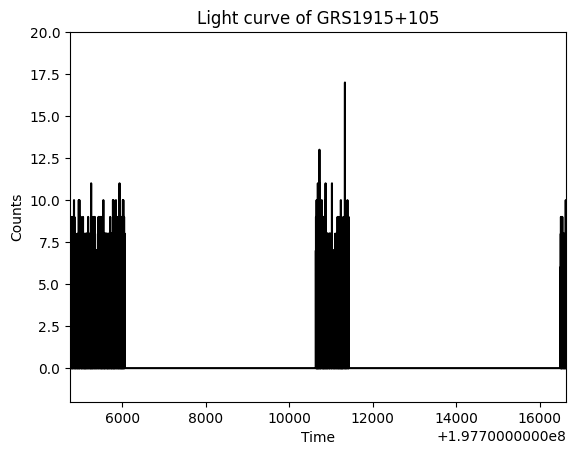

In [51]:
lc = Lightcurve.read("lg_g0_0-94.lc", fmt="hea",err_dist="gauss")
lc.plot(labels=('Time','Counts'),
        axis=(197704748,197716627,-2,20),
        title="Light curve of GRS1915+105",
        marker = 'k',
        save=True, filename="lightcurve.png") #绘制光变曲线并保存

lc.gti #查看gti


### Splitting Light Curves
split(min_gap, min_points=1)[source]
For data with gaps, it can sometimes be useful to be able to split the light curve into separate, evenly sampled objects along those data gaps. This method allows to do this: it finds data gaps of a specified minimum size, and produces a list of new Lightcurve objects for each contiguous segment.


lc_split = lc.split(min_gap=2*lc.dt)  #分割光变曲线

for lc_tmp in lc_split: $ \quad  $   $ \quad  $  $ \quad  $     $ \quad   $    #可以通过min_gap属性调整可接受的间隙大小的公差。也可以在输出的光照曲线中要求一个最小的数据点数量（min_points）。

$ \quad  $    print(lc_tmp.time)
    
lc.dt $ \quad  $ $ \quad  $ $ \quad  $ $ \quad  $ $ \quad  $  $ \quad  $ $ \quad  $  $ \quad  $  $ \quad  $#时间间隔 （这里是1/128s的分辨率）

In [58]:
lc_split = lc.split_by_gti()
for lc_tmp in lc_split: #按照gti划分，任何落在gti之外的事件都会丢失
    print(lc_tmp.time)

lc1 = lc_split[0] #取划分之后的第一段光变曲线
### mjdref：MJD参考时间，光变曲线时间从0开始（具体见网页）
lc1.mjdref

[1.97704749e+08 1.97704749e+08 1.97704749e+08 ... 1.97706059e+08
 1.97706059e+08 1.97706059e+08]
[1.97710636e+08 1.97710636e+08 1.97710636e+08 ... 1.97711427e+08
 1.97711427e+08 1.97711427e+08]
[1.97716495e+08 1.97716495e+08 1.97716495e+08 ... 1.97716626e+08
 1.97716626e+08 1.97716626e+08]


55927.00076601852

In [44]:
print(lc1[120])          #对特定时间的计数率进行索引
lc_sliced = lc1[100:200] #对光变曲线进行切片
print(len(lc_sliced.counts))    #给出光变曲线计数率
print(lc.time[-1])       #查看时间
lc_rebinned =lc1.rebin(1)   #重新设置更大的时间分辨率，不需要是旧的整数倍，但是最后一个bin可能会被分数切断
print("Old time resolution = " + str(lc1.dt))
print("Number of data points = " + str(lc1.n))
print("New time resolution = " + str(lc_rebinned.dt))
print("Number of data points = " + str(lc_rebinned.n))

1.0
100
197716626.49843752384
Old time resolution = 0.0071250000000000002567
Number of data points = 184000
New time resolution = 1
Number of data points = 1311


In [53]:
#检查符合条件的片段：每个片段至少有两个bin，同时要求片段中的总计数超过300，结果给出我们需要2.1375s
min_total_counts = 300
min_total_bins = 2 
estimated_chunk_length = lc.estimate_chunk_length(min_total_bins,min_total_counts)
print("The estimated length of each segment in seconds to satisfy both conditions is : "+str(estimated_chunk_length))

The estimated length of each segment in seconds to satisfy both conditions is : 2.137500000000000077


In [57]:
#使用这些片段进行分析
start_times, stop_times, lc_sums =lc.analyze_lc_chunks(segment_size=100.0, func=np.median)
#把光变曲线分成了10s的片段，然后找出每个片段的中位数。也可以使用自定义函数传递给func
lc_sums

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       1., 1., 1., 1.])

### Averagedpowerspectrum
class stingray.AveragedPowerspectrum(data=None, segment_size=None, norm='frac', gti=None, silent=False, dt=None, lc=None, large_data=False, save_all=False, skip_checks=False, use_common_mean=True, legacy=False)[source]

#### static from_events(events, dt, segment_size=None, gti=None, norm='frac', silent=False, use_common_mean=True)
Calculate an average power spectrum from an event list.
- norm：str, default “frac” ：
The normalization of the periodogram. abs is absolute rms, frac is fractional rms, leahy is Leahy+83 normalization, and none is the unnormalized periodogram.



In [19]:
pds = AveragedPowerspectrum.from_events(lc1, segment_size=64, dt=1/128, norm='leahy')

20it [00:00, 1202.65it/s]


Text(0, 0.5, 'Power (Leahy)')

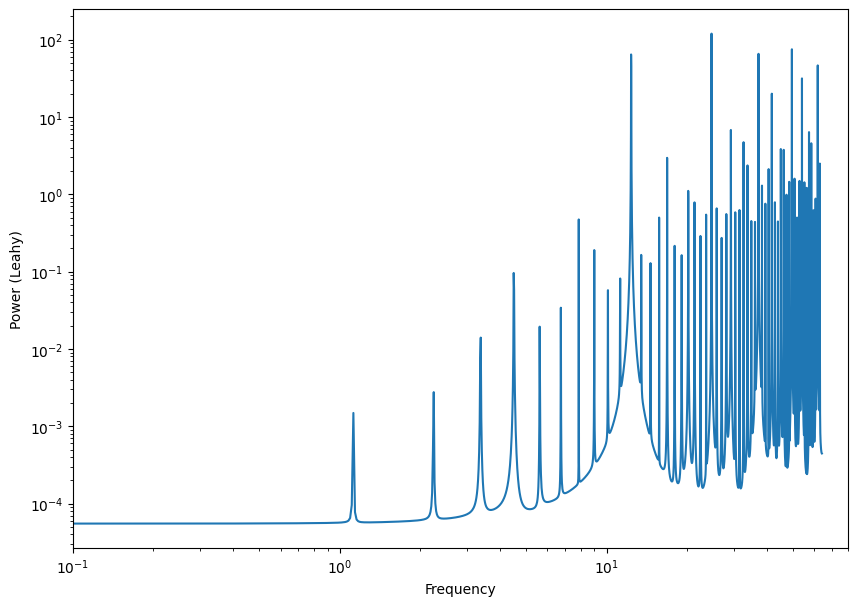

In [20]:
plt.figure(figsize=(10,7))
plt.loglog(pds.freq, pds.power)
plt.xlim([0.1, 80])
plt.xlabel("Frequency")
plt.ylabel("Power (Leahy)")